In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# --- 0. Configurare Locală ---
os.environ["WANDB_DISABLED"] = "true"
model_checkpoint = "distilbert-base-uncased"

# Verificăm dacă vedem placa video
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Antrenare Locală pe {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# --- 1. Definim cele 9 Clase Țintă (Plutchik) ---
target_labels = ["anger", "anticipation", "disgust", "fear", "joy", "neutral", "sadness", "surprise", "trust"]
label2id = {label: i for i, label in enumerate(target_labels)}
id2label = {i: label for i, label in enumerate(target_labels)}

# --- 2. Încărcare și Procesare Date ---
# Încărcăm CSV-ul colegului (Asigură-te că fișierul e în același folder!)
try:
    df = pd.read_csv("sentimentdataset.csv") 
except:
    print("❌ Eroare: Nu găsesc fișierul 'date_coleg.csv'. Verifică numele.")
    exit()

# Funcția de mapare (50+ nuanțe -> 9 clase)
def map_label_to_9_classes(row_label):
    label = str(row_label).strip().lower()
    
    if label in ['joy', 'happiness', 'love', 'amusement', 'enjoyment', 'admiration', 
                 'affection', 'excitement', 'pride', 'elation', 'euphoria', 'contentment', 
                 'serenity', 'gratitude', 'empowerment', 'compassion', 'tenderness', 
                 'arousal', 'enthusiasm', 'fulfillment', 'relief', 'optimism', 'zest', 
                 'thrill', 'charm', 'ecstasy', 'radiance', 'rejuvenation', 'coziness',
                 'happy', 'positive', 'cheerful', 'delight', 'bliss', 'satisfaction']:
        return label2id['joy']
    elif label in ['sadness', 'disappointed', 'grief', 'loneliness', 'depression', 
                   'sorrow', 'heartbreak', 'regret', 'remorse', 'misery', 'despair', 
                   'suffering', 'desolation', 'yearning', 'melancholy', 'nostalgia', 
                   'isolation', 'exhaustion', 'darkness', 'loss', 'helplessness']:
        return label2id['sadness']
    elif label in ['anger', 'annoyance', 'bitterness', 'bitter', 'resentment', 
                   'frustration', 'jealousy', 'jealous', 'envy', 'hate', 'betrayal', 
                   'fury', 'rage', 'hostility', 'disapproval']:
        return label2id['anger']
    elif label in ['fear', 'nervousness', 'anxiety', 'intimidation', 'apprehensive', 
                   'overwhelmed', 'fearful', 'scared', 'panic', 'horror', 'worry']:
        return label2id['fear']
    elif label in ['disgust', 'loathing', 'revulsion', 'dislike']:
        return label2id['disgust']
    elif label in ['surprise', 'confusion', 'awe', 'wonder', 'wonderment', 'dazzle', 
                   'whimsy', 'curiosity', 'intrigue', 'enchantment', 'shock', 'amazement']:
        return label2id['surprise']
    elif label in ['trust', 'acceptance', 'reverence', 'faith', 'confidence', 'believing']:
        return label2id['trust']
    elif label in ['anticipation', 'hope', 'hopeful', 'expectancy', 'planning']:
        return label2id['anticipation']
    elif label in ['neutral', 'calmness', 'indifference', 'numbness', 'pensive', 
                   'reflection', 'contemplation', 'mindfulness']:
        return label2id['neutral']
    return -1

print("🔄 Mapez etichetele...")
df['mapped_label'] = df['Sentiment'].apply(map_label_to_9_classes)
df_clean = df[df['mapped_label'] != -1].copy()

# Split Train/Test
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['mapped_label'])
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# --- 3. Tokenizare ---
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize_function(examples):
    # Păstrăm 128 lungime, e safe pentru memorie
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=128)

print("✂️ Tokenizez datele...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Formatare coloane
tokenized_train = tokenized_train.rename_column("mapped_label", "labels")
tokenized_test = tokenized_test.rename_column("mapped_label", "labels")
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# --- 4. Calcul Ponderi (Să nu ignore clasele mici) ---
train_labels_array = np.array(train_df['mapped_label'])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels_array),
    y=train_labels_array
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"⚖️ Ponderi: {weights_tensor}")

# --- 5. Modelul (9 Labels) ---
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=9)
model.to(device)

# --- 6. Trainer Personalizat ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- 7. Setări Optimizate GTX 1650 (LOW VRAM) ---
training_args = TrainingArguments(
    output_dir="./rezultate_local_1650",
    
    # === SETĂRI CRITICE PENTRU 4GB VRAM ===
    per_device_train_batch_size=8,   # Micșorat de la 32 la 8
    gradient_accumulation_steps=4,   # Crește batch-ul efectiv la 32 (8*4)
    per_device_eval_batch_size=16,   # La evaluare putem pune puțin mai mult
    fp16=True,                       # Folosește Mixed Precision (consumă mai puțină memorie)
    dataloader_num_workers=0,        # Critic pentru Windows local! Altfel crapă.
    # ======================================
    
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,              # 5 epoci e un start bun
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_steps=50,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

print("🏁 Start Antrenare pe GTX 1650...")
trainer.train()

trainer.save_model("./model_coleg_local_9clase")
print("✅ Gata! Model salvat local.")

🚀 Antrenare Locală pe NVIDIA GeForce GTX 1650
🔄 Mapez etichetele...
✂️ Tokenizez datele...


Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

⚖️ Ponderi: tensor([ 1.5889,  3.4048, 11.9167,  3.9722,  0.2138,  1.4020,  0.7814,  1.1626,
         4.7667], device='cuda:0')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏁 Start Antrenare pe GTX 1650...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.128772,0.333333,0.157037,0.279284,0.245142
2,No log,2.057832,0.453704,0.237009,0.242732,0.277441
3,No log,1.969057,0.620370,0.368970,0.370966,0.392039
4,2.049100,1.912695,0.601852,0.435875,0.514635,0.425818
5,2.049100,1.889632,0.601852,0.426788,0.493386,0.425818


✅ Gata! Model salvat local.


🔍 Evaluare pe cuda...
🚀 Generez predicții...


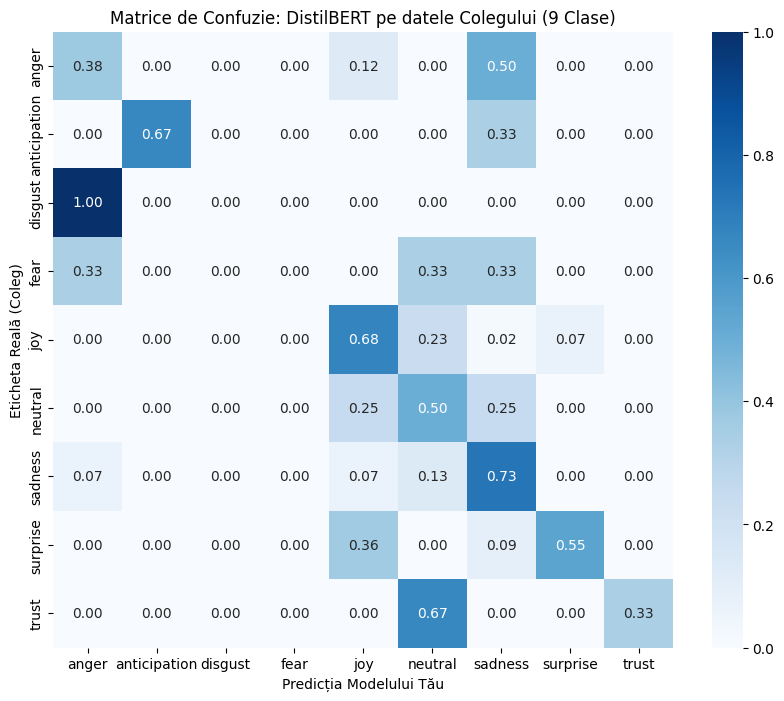


=== Raport Detaliat ===
              precision    recall  f1-score   support

       anger       0.50      0.38      0.43         8
anticipation       1.00      0.67      0.80         3
     disgust       0.00      0.00      0.00         1
        fear       0.00      0.00      0.00         3
         joy       0.83      0.68      0.75        56
     neutral       0.18      0.50      0.27         8
     sadness       0.52      0.73      0.61        15
    surprise       0.60      0.55      0.57        11
       trust       1.00      0.33      0.50         3

    accuracy                           0.60       108
   macro avg       0.51      0.43      0.44       108
weighted avg       0.67      0.60      0.62       108



In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# 1. Configurare
model_path = "./model_coleg_local_9clase"  # Folderul unde ai salvat modelul
target_labels = ["anger", "anticipation", "disgust", "fear", "joy", "neutral", "sadness", "surprise", "trust"]

# Verificăm GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔍 Evaluare pe {device}...")

# 2. Încărcăm modelul antrenat și tokenizer-ul
try:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") # Tokenizer-ul de bază e ok
    model.to(device)
except Exception as e:
    print(f"Eroare la încărcare: {e}")
    print("Asigură-te că folderul './model_coleg_local_9clase' există.")
    exit()

# 3. Trebuie să re-creăm setul de test (Test Dataset)
# (Folosim aceleași funcții de procesare ca la antrenare pentru consistență)
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# ... REPETĂM PARTEA DE ÎNCĂRCARE A DATELOR ...
# (Copiază funcția map_label_to_9_classes din scriptul anterior aici, sau import-o)
# Pentru simplitate, presupunem că ai variabilele `test_dataset` și `tokenized_test` 
# disponibile dacă ești în același notebook/script.
# DACĂ ESTE UN SCRIPT NOU, COPIAZĂ ACEASTĂ SECȚIUNE DE MAI JOS:

# --- SECȚIUNE DE ÎNCĂRCARE DATE (Doar dacă e script nou) ---
df = pd.read_csv("sentimentdataset.csv")
# ... (pune aici funcția map_label_to_9_classes din scriptul anterior) ...
# df['mapped_label'] = df['Sentiment'].apply(map_label_to_9_classes)
# df_clean = df[df['mapped_label'] != -1].copy()
# _, test_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['mapped_label'])
# test_dataset = Dataset.from_pandas(test_df)
# def tokenize_function(examples):
#    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=128)
# tokenized_test = test_dataset.map(tokenize_function, batched=True)
# tokenized_test = tokenized_test.rename_column("mapped_label", "labels")
# tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
# -----------------------------------------------------------

# 4. Facem Predicții
print("🚀 Generez predicții...")
from transformers import TrainingArguments

# Definim un Trainer gol doar pentru predicție
eval_args = TrainingArguments(output_dir="./temp_eval", per_device_eval_batch_size=16, report_to="none")
trainer = Trainer(model=model, args=eval_args)

# Rulăm predicția pe setul de test
predictions_output = trainer.predict(tokenized_test)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# 5. Generăm Matricea
cm = confusion_matrix(labels, preds)
# Normalizăm pe rânduri (ca să vedem procentaje)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 6. Desenăm
plt.figure(figsize=(10, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_labels, yticklabels=target_labels, cmap="Blues")
plt.ylabel('Eticheta Reală (Coleg)')
plt.xlabel('Predicția Modelului Tău')
plt.title('Matrice de Confuzie: DistilBERT pe datele Colegului (9 Clase)')
plt.show()

# 7. Raport detaliat
print("\n=== Raport Detaliat ===")
print(classification_report(labels, preds, target_names=target_labels, zero_division=0))

🚀 Antrenare Identică (Split Replicat) pe cuda
Date Train: 429 | Date Test: 108


Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏁 Start Antrenare...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.186500,2.131715,0.259259,0.107362,0.242985,0.165416
2,2.100200,2.040230,0.611111,0.386522,0.443114,0.394781
3,1.949600,1.919509,0.666667,0.445158,0.490570,0.451611
4,1.849300,1.796232,0.675926,0.491285,0.501997,0.503247
5,1.620700,1.683152,0.731481,0.532588,0.528257,0.567532
6,1.485600,1.589954,0.703704,0.515392,0.479990,0.571188
7,1.410800,1.515676,0.731481,0.533337,0.499855,0.589045
8,1.299100,1.462544,0.703704,0.507978,0.466960,0.576611
9,1.220000,1.424974,0.712963,0.524062,0.479822,0.598617
10,1.196200,1.414883,0.712963,0.520229,0.478953,0.590500


📊 Generare Matrice de Confuzie...


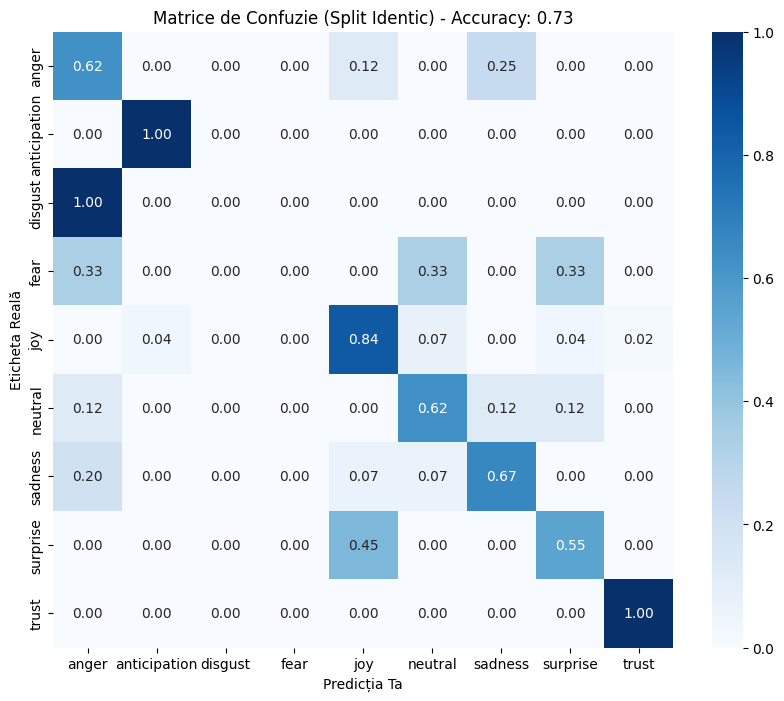

✅ Gata!


In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. Configurare Locală ---
os.environ["WANDB_DISABLED"] = "true"
model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Antrenare Identică (Split Replicat) pe {device}")

# --- 1. Definim cele 9 Clase Țintă (Plutchik) ---
target_labels = ["anger", "anticipation", "disgust", "fear", "joy", "neutral", "sadness", "surprise", "trust"]
label2id = {label: i for i, label in enumerate(target_labels)}
id2label = {i: label for i, label in enumerate(target_labels)}

# --- 2. Încărcare și Procesare Date ---
try:
    df = pd.read_csv("sentimentdataset.csv") 
except:
    print("❌ Eroare: Nu găsesc fișierul 'date_coleg.csv'.")
    exit()

# Funcția de Mapare (Aceeași ca înainte)
def map_label_to_9_classes(row_label):
    label = str(row_label).strip().lower()
    
    # JOY Group
    if label in ['joy', 'happiness', 'love', 'amusement', 'enjoyment', 'admiration', 
                 'affection', 'excitement', 'pride', 'elation', 'euphoria', 'contentment', 
                 'serenity', 'gratitude', 'empowerment', 'compassion', 'tenderness', 
                 'arousal', 'enthusiasm', 'fulfillment', 'relief', 'optimism', 'zest', 
                 'thrill', 'charm', 'ecstasy', 'radiance', 'rejuvenation', 'coziness',
                 'happy', 'positive', 'cheerful', 'delight', 'bliss', 'satisfaction']:
        return label2id['joy']
    # SADNESS Group
    elif label in ['sadness', 'disappointed', 'grief', 'loneliness', 'depression', 
                   'sorrow', 'heartbreak', 'regret', 'remorse', 'misery', 'despair', 
                   'suffering', 'desolation', 'yearning', 'melancholy', 'nostalgia', 
                   'isolation', 'exhaustion', 'darkness', 'loss', 'helplessness']:
        return label2id['sadness']
    # ANGER Group
    elif label in ['anger', 'annoyance', 'bitterness', 'bitter', 'resentment', 
                   'frustration', 'jealousy', 'jealous', 'envy', 'hate', 'betrayal', 
                   'fury', 'rage', 'hostility', 'disapproval']:
        return label2id['anger']
    # FEAR Group
    elif label in ['fear', 'nervousness', 'anxiety', 'intimidation', 'apprehensive', 
                   'overwhelmed', 'fearful', 'scared', 'panic', 'horror', 'worry']:
        return label2id['fear']
    # DISGUST Group
    elif label in ['disgust', 'loathing', 'revulsion', 'dislike']:
        return label2id['disgust']
    # SURPRISE Group
    elif label in ['surprise', 'confusion', 'awe', 'wonder', 'wonderment', 'dazzle', 
                   'whimsy', 'curiosity', 'intrigue', 'enchantment', 'shock', 'amazement']:
        return label2id['surprise']
    # TRUST Group
    elif label in ['trust', 'acceptance', 'reverence', 'faith', 'confidence', 'believing']:
        return label2id['trust']
    # ANTICIPATION Group
    elif label in ['anticipation', 'hope', 'hopeful', 'expectancy', 'planning']:
        return label2id['anticipation']
    # NEUTRAL Group
    elif label in ['neutral', 'calmness', 'indifference', 'numbness', 'pensive', 
                   'reflection', 'contemplation', 'mindfulness']:
        return label2id['neutral']
    return -1

# Mapare
df['mapped_label'] = df['Sentiment'].apply(map_label_to_9_classes)
df_clean = df[df['mapped_label'] != -1].copy()

# === AICI ESTE REPLICAREA EXACTĂ A COLEGULUI ===
# test_size=0.2, random_state=42, stratify=labels
train_df, test_df = train_test_split(
    df_clean, 
    test_size=0.2, 
    random_state=42,          # <--- Magic Number
    stratify=df_clean['mapped_label'] # <--- Păstrează proporțiile
)
# ===============================================

print(f"Date Train: {len(train_df)} | Date Test: {len(test_df)}")

# Conversie Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# --- 3. Tokenizare ---
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Formatare
tokenized_train = tokenized_train.rename_column("mapped_label", "labels")
tokenized_test = tokenized_test.rename_column("mapped_label", "labels")
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# --- 4. Ponderi pentru clase dezechilibrate ---
train_labels_array = np.array(train_df['mapped_label'])
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_array), y=train_labels_array)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# --- 5. Trainer Setup ---
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=9)
model.to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir="./rezultate_exacte_coleg",
    
    # Configurare GTX 1650
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    fp16=True,
    dataloader_num_workers=0,
    
    # Antrenare mai lungă pentru seturi mici
    num_train_epochs=10,            # <--- Mărit la 10 epoci!
    learning_rate=2e-5,
    weight_decay=0.01,
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    logging_steps=10,              # <--- Log mai des ca să vezi progresul
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

print("🏁 Start Antrenare...")
trainer.train()

# --- 6. Evaluare Finală și Matrice Confuzie ---
print("📊 Generare Matrice de Confuzie...")
preds_output = trainer.predict(tokenized_test)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_labels, yticklabels=target_labels, cmap="Blues")
plt.ylabel('Eticheta Reală')
plt.xlabel('Predicția Ta')
plt.title(f'Matrice de Confuzie (Split Identic) - Accuracy: {accuracy_score(labels, preds):.2f}')
plt.show()

print("✅ Gata!")